**This notebook focuses on the effectiveness of Total Variance Minimization against adversarial attacks on the CIFAR-10 dataset.**

## **Section 0 - Setting Up**

### **Load prerequisites**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, Layer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from art import config
from art.attacks.evasion import FastGradientMethod, DeepFool, ProjectedGradientDescent, SaliencyMapMethod, CarliniL2Method, NewtonFool, BasicIterativeMethod
from art.defences.preprocessor import TotalVarMin
from art.defences.trainer import AdversarialTrainer
from art.estimators.classification import KerasClassifier
from art.utils import load_cifar10

### **Disable eager execution to enable adversarial crafting and ART classifier**

In [2]:
tf.compat.v1.disable_eager_execution()

### **Load CIFAR-10 dataset**

In [15]:
def cifar10_class(class_number):
    switcher={
        0: 'Airplane',
        1: 'Automobile',
        2: 'Bird',
        3: 'Cat',
        4: 'Deer',
        5: 'Dog',
        6: 'Frog',
        7: 'Horse',
        8: 'Ship',
        9: 'Truck'
    }
    return switcher.get(class_number)

In [3]:
(x_train_cln, y_train_cln), (x_test_cln, y_test_cln), min_pixel_value, max_pixel_value = load_cifar10()
# x_test_cln, y_test_cln = x_test_cln[:100], y_test_cln[:100]

### **Create CIFAR-10 classifier model**

*Load MARVEL pre-trained model*

In [4]:
model = load_model("/home/cyber/Desktop/Adrian/cifar10_trained_model.h5")

*Create ART classifier*

In [5]:
classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

## **Section 1 - Attack**

Step 1: Evaluate the classifier on the clean test set

In [7]:
predictions_cln = classifier.predict(x_test_cln)
accuracy_cln = np.sum(np.argmax(predictions_cln, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("Accuracy on clean test examples: {}%".format(accuracy_cln * 100))

/home/cyber/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy on clean test examples: 88.87%


Step 2: Split clean test examples into true and false positives

In [8]:
tp_cln_indexes=[]
fp_cln_indexes=[]
x_test_cln_tp=[]
y_test_cln_tp=[]
x_test_cln_fp=[]
y_test_cln_fp=[]

for k in range(len(predictions_cln)):
    if(np.argmax(predictions_cln, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k]):
        tp_cln_indexes.append(k)
    else:
        fp_cln_indexes.append(k)

for k in tp_cln_indexes:
    x_test_cln_tp.append(x_test_cln[k])
    y_test_cln_tp.append(y_test_cln[k])
    
for k in fp_cln_indexes:
    x_test_cln_fp.append(x_test_cln[k])
    y_test_cln_fp.append(y_test_cln[k])
    
x_test_cln_tp = np.array(x_test_cln_tp)
x_test_cln_fp = np.array(x_test_cln_fp)

print('Number of clean true positives: {:}'.format(len(x_test_cln_tp)))
print('Number of clean false positives: {:}'.format(len(x_test_cln_fp)))

Number of clean true positives: 8887
Number of clean false positives: 1113


Step 3: Craft adversarial examples

*Craft Jacobian-based Saliency Map Attack (JSMA) attacks*

In [9]:
# attack = SaliencyMapMethod(classifier=classifier, theta = 0.1, gamma=1, verbose=True)
# x_test_JSMA_cifar10 = attack.generate(x_test_cln)
# %store x_test_JSMA_cifar10

*Craft Basic Iterative Method (BMI) attacks*

In [10]:
# attack = BasicIterativeMethod(classifier, eps=3/255, eps_step=1/255, max_iter=100)
# x_test_BIM_cifar10 = attack.generate(x_test_cln)
# %store x_test_BIM_cifar10

*Craft Projected Gradient Descent (PGD) attacks*

In [11]:
# attack = ProjectedGradientDescent(classifier, eps=3/255, eps_step=1/255, max_iter=100)
# x_test_PGD_cifar10 = attack.generate(x_test_cln)
# %store x_test_PGD_cifar10

*Craft NewtonFool attacks*

In [12]:
# attack =  NewtonFool(classifier=classifier, eta=1/255, max_iter=100, verbose=True)
# x_test_Newton_cifar10 = attack.generate(x_test_cln)
# %store x_test_Newton_cifar10

*Craft DeepFool attacks*

In [13]:
# attack = DeepFool(classifier=classifier, epsilon=1e-06/255, max_iter=100)
# x_test_Deep_cifar10 = attack.generate(x_test_cln)
# %store x_test_Deep_cifar10

*Alternatively, load existing adversarial attacks*

In [18]:
attack_name = 'DeepFool'
%store -r x_test_JSMA_cifar10
x_test_adv = x_test_JSMA_cifar10

Step 4: Evaluate the classifier on the adversarial test set

In [20]:
predictions_adv = classifier.predict(x_test_adv)
accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test_cln, axis=1)) / len(y_test_cln)

print("Accuracy on adversarial test examples: {}%".format(accuracy_adv * 100))

Accuracy on adversarial test examples: 6.84%


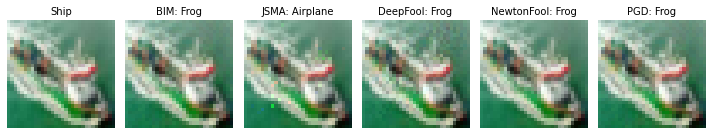

In [29]:
i = 15

x_test_JSMA_cifar10_ref = x_test_JSMA_cifar10[i]
predictions_jsma = classifier.predict(x_test_JSMA_cifar10[i:])

x_test_BIM_cifar10_ref = x_test_BIM_cifar10[i]
predictions_bim = classifier.predict(x_test_BIM_cifar10[i:])

x_test_Deep_cifar10_ref = x_test_Deep_cifar10[i]
predictions_deep = classifier.predict(x_test_Deep_cifar10[i:])

x_test_Newton_cifar10_ref = x_test_Newton_cifar10[i]
predictions_newton = classifier.predict(x_test_Newton_cifar10[i:])

x_test_PGD_cifar10_ref = x_test_PGD_cifar10[i]
predictions_pgd = classifier.predict(x_test_PGD_cifar10[i:])

# Plot images
plt.figure(figsize=(10, 10))

ax = plt.subplot(1, 6, 1)
plt.imshow(x_test_cln[i], cmap='gray')
ax.set_title('Ship', fontsize=10, loc='center', wrap=True)#.format(np.argmax(y_test_cln,axis=1)[i]))
plt.axis("off")

ax = plt.subplot(1, 6, 2)
plt.imshow(x_test_BIM_cifar10_ref, cmap='gray')
ax.set_title('BIM: Frog', fontsize=10, loc='center', wrap=True)#format(np.argmax(predictions_bim,axis=1)[0]))
plt.axis("off")

ax = plt.subplot(1, 6, 3)
plt.imshow(x_test_JSMA_cifar10_ref, cmap='gray')
ax.set_title('JSMA: Airplane', fontsize=10, loc='center', wrap=True)#{:}'.format(np.argmax(predictions_jsma,axis=1)[0]))
plt.axis("off")

ax = plt.subplot(1, 6, 4)
plt.imshow(x_test_Deep_cifar10_ref, cmap='gray')
ax.set_title('DeepFool: Frog', fontsize=10, loc='center', wrap=True)#.format(np.argmax(predictions_deep,axis=1)[0]))
plt.axis("off")

ax = plt.subplot(1, 6, 5)
plt.imshow(x_test_Newton_cifar10_ref, cmap='gray')
ax.set_title('NewtonFool: Frog', fontsize=10, loc='center', wrap=True)#.format(np.argmax(predictions_newton,axis=1)[0]))
plt.axis("off")

ax = plt.subplot(1, 6, 6)
plt.imshow(x_test_PGD_cifar10_ref, cmap='gray')
ax.set_title('PGD: Frog', fontsize=10, loc='center', wrap=True)#.format(np.argmax(predictions_pgd,axis=1)[0]))
plt.axis("off")

image_path = '/home/cyber/Desktop/Adrian/attacks-cifar10.png'
plt.savefig(image_path, dpi=500, transparent=True)
plt.tight_layout()
plt.show()

Step 5: Split the adversarial test examples into true and false positives

In [53]:
tp_adv_indexes=[]
fp_adv_indexes=[]
x_test_adv_tp=[]
y_test_adv_tp=[]
x_test_adv_fp=[]
y_test_adv_fp=[]

for k in range(len(predictions_adv)):
    if(np.argmax(predictions_adv, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k]):
        tp_adv_indexes.append(k)
    else:
        fp_adv_indexes.append(k)

for k in tp_adv_indexes:
    x_test_adv_tp.append(x_test_adv[k])
    y_test_adv_tp.append(y_test_cln[k])
    
for k in fp_adv_indexes:
    x_test_adv_fp.append(x_test_adv[k])
    y_test_adv_fp.append(y_test_cln[k])
    
x_test_adv_tp = np.array(x_test_adv_tp)
x_test_adv_fp = np.array(x_test_adv_fp)

print('Adversarial TP: {:}'.format(len(x_test_adv_tp)))
print('Adversarial FP: {:}'.format(len(x_test_adv_fp)))

Adversarial TP: 130
Adversarial FP: 9870


Step 6: Plot clean test examples and their adversarial counterparts

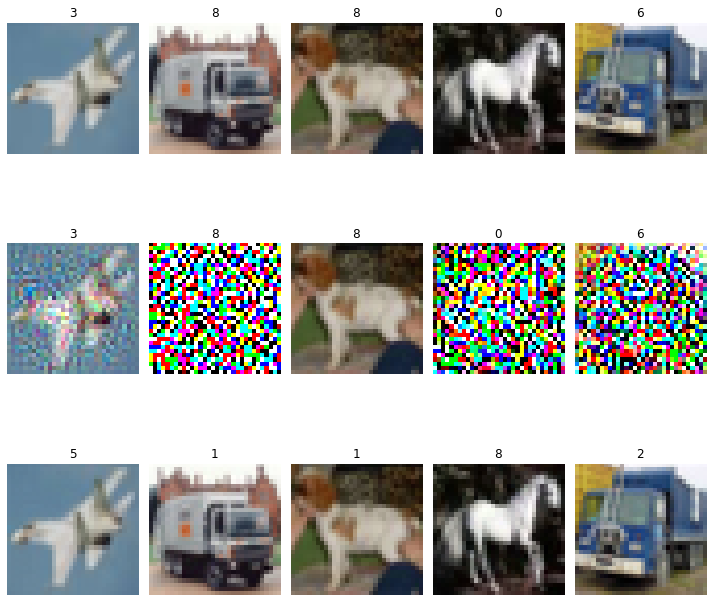

In [32]:
# Plot images
plt.figure(figsize=(10, 10))

for i in range(10):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(x_test_z[i], cmap='gray')
    ax.set_title('{:}'.format(np.argmax(y_test_cln,axis=1)[i]))
    plt.axis("off")
    
    ax = plt.subplot(4, 5, i + 11)
    plt.imshow(x_test_adv[i], cmap='gray')
    ax.set_title('{:}'.format(np.argmax(predictions_adv,axis=1)[i]))
    plt.axis("off")
    
plt.tight_layout()
plt.show()

## **Section 2 - Defence**

### **Total Variance Minimization**

Step 1: Transform input

In [55]:
defence = TotalVarMin(lamb=0.05, verbose=True)

In [56]:
x_test_cln_tp_tvm = defence(x_test_cln_tp*255)[0]/255
x_test_cln_fp_tvm = defence(x_test_cln_fp*255)[0]/255
x_test_cln_tvm = np.concatenate((x_test_cln_tp_tvm, x_test_cln_fp_tvm), axis=0)
y_test_cln_tvm = y_test_cln_tp + y_test_cln_fp

Variance minimization:   0%|          | 0/8887 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/1113 [00:00<?, ?it/s]

In [57]:
x_test_adv_tp_tvm = defence(x_test_adv_tp*255)[0]/255 
x_test_adv_fp_tvm = defence(x_test_adv_fp*255)[0]/255
x_test_adv_tvm = np.concatenate((x_test_adv_tp_tvm, x_test_adv_fp_tvm), axis=0)
y_test_adv_tvm = y_test_adv_tp + y_test_adv_fp

Variance minimization:   0%|          | 0/130 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/9870 [00:00<?, ?it/s]

Step 2: Evaluate the classifier on all 4 sets of data after TotalVarMin

In [58]:
predictions_cln_tvm = classifier.predict(x_test_cln_tvm)
accuracy_cln_tvm = np.sum(np.argmax(predictions_cln_tvm, axis=1) == np.argmax(y_test_cln_tvm, axis=1)) / len(y_test_cln_tvm)

print("Effect of TotalVarMin on entire clean test set: {:.2f}%".format((accuracy_cln_tvm - accuracy_cln) * 100))
 
predictions_cln_tp_tvm = classifier.predict(x_test_cln_tp_tvm)
accuracy_cln_tp_tvm = np.sum(np.argmax(predictions_cln_tp_tvm, axis=1) == np.argmax(y_test_cln_tp, axis=1)) / len(y_test_cln_tp)

# print("\nAccuracy on true positive clean test examples after TotalVarMin: {:.2f}%".format(accuracy_cln_tp_tvm * 100))
print("\nAccuracy drop on true positive clean test examples after TotalVarMin: {:.2f}%".format((1 - accuracy_cln_tp_tvm) * 100))

predictions_cln_fp_tvm = classifier.predict(x_test_cln_fp_tvm)
accuracy_cln_fp_tvm = np.sum(np.argmax(predictions_cln_fp_tvm, axis=1) == np.argmax(y_test_cln_fp, axis=1)) / len(y_test_cln_fp)

print("\nAccuracy increase on false positive clean test examples after TotalVarMin: {:.2f}%".format(accuracy_cln_fp_tvm * 100))

predictions_adv_tvm = classifier.predict(x_test_adv_tvm)
accuracy_adv_tvm = np.sum(np.argmax(predictions_adv_tvm, axis=1) == np.argmax(y_test_adv_tvm, axis=1)) / len(y_test_adv_tvm)

print("\nEffect of TotalVarMin on entire adversarial test set: {:.2f}%".format((accuracy_adv_tvm-accuracy_adv) * 100))

predictions_adv_tp_tvm = classifier.predict(x_test_adv_tp_tvm)
accuracy_adv_tp_tvm = np.sum(np.argmax(predictions_adv_tp_tvm, axis=1) == np.argmax(y_test_adv_tp, axis=1)) / len(y_test_adv_tp)

# print("\nAccuracy on true positive adversarial test examples after TotalVarMin: {:.2f}%".format(accuracy_adv_tp_tvm * 100))
print("\nAccuracy drop on true positive adversarial test examples after TotalVarMin: {:.2f}%".format((1 - accuracy_adv_tp_tvm) * 100))

predictions_adv_fp_tvm = classifier.predict(x_test_adv_fp_tvm)
accuracy_adv_fp_tvm = np.sum(np.argmax(predictions_adv_fp_tvm, axis=1) == np.argmax(y_test_adv_fp, axis=1)) / len(y_test_adv_fp)

print("\nAccuracy increase on false positive adversarial test examples after TotalVarMin: {:.2f}%".format(accuracy_adv_fp_tvm * 100))

Effect of TotalVarMin on entire clean test set: -15.09%

Accuracy drop on true positive clean test examples after TotalVarMin: 19.50%

Accuracy increase on false positive clean test examples after TotalVarMin: 20.13%

Effect of TotalVarMin on entire adversarial test set: 52.38%

Accuracy drop on true positive adversarial test examples after TotalVarMin: 57.69%

Accuracy increase on false positive adversarial test examples after TotalVarMin: 53.83%


Step 3: Plot all data pre- and post-transformation

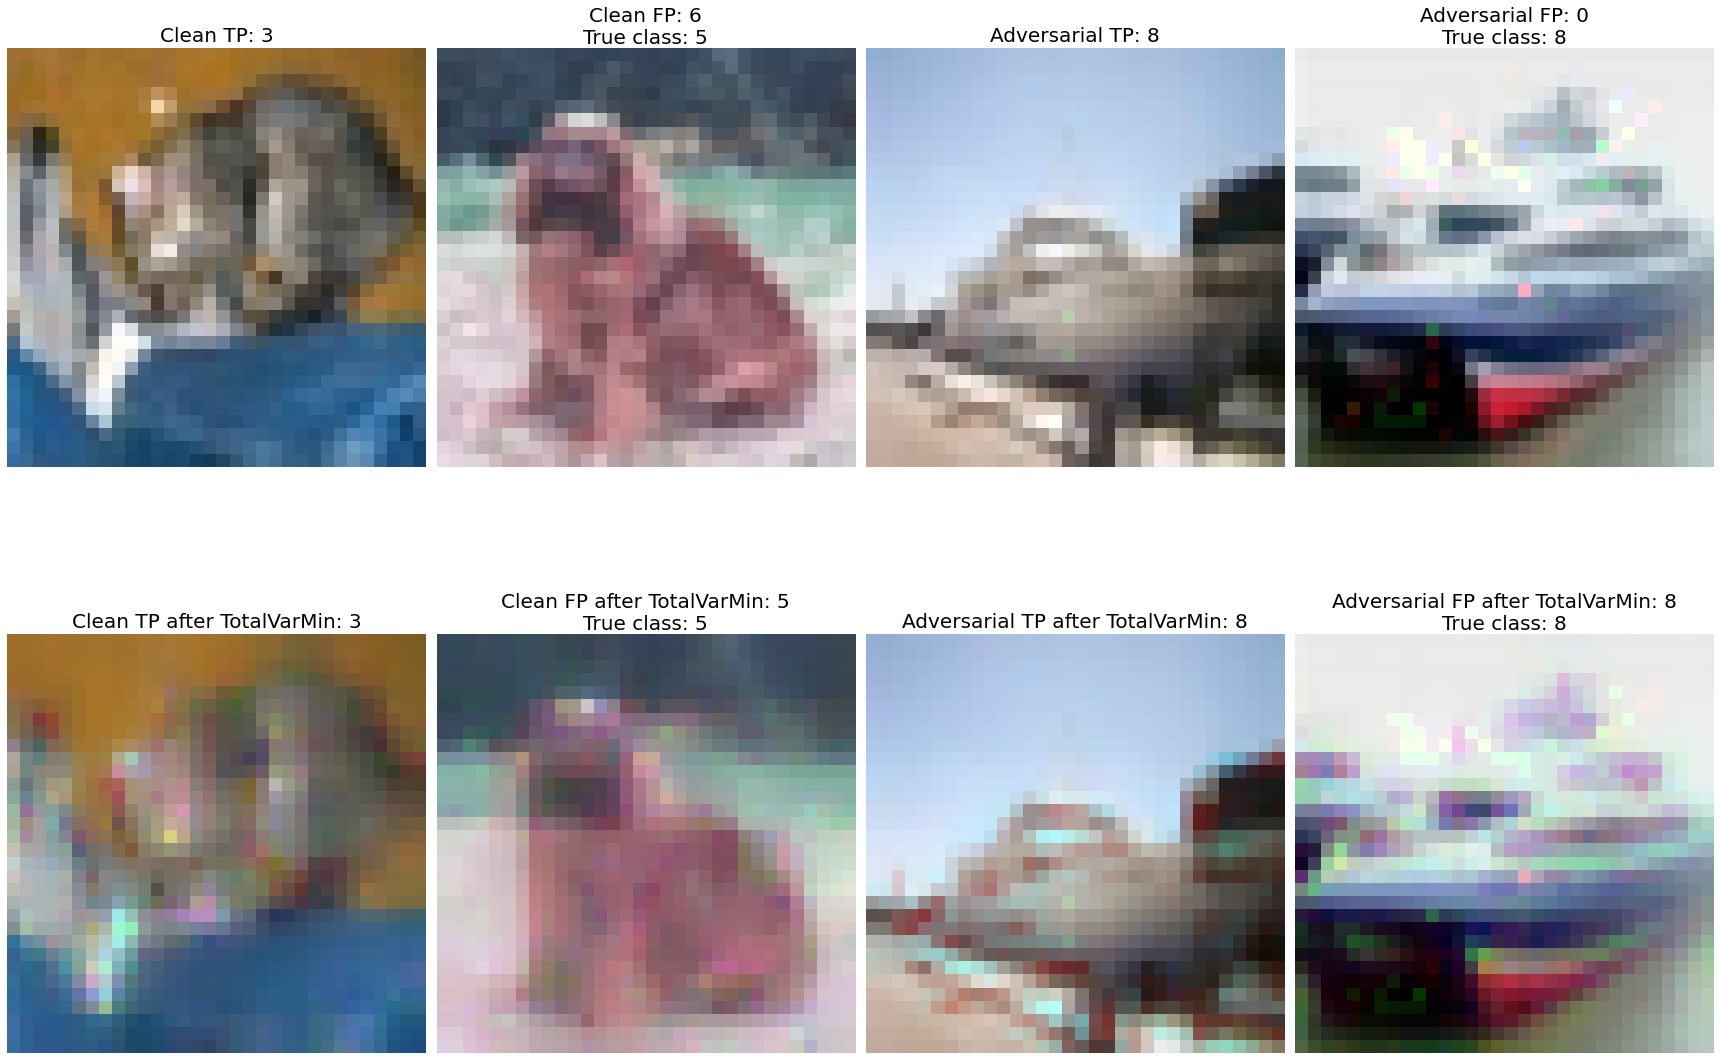

In [59]:
# Get index of successful TotalVarMin transformations
succ_cln_tp_idx=[]
succ_cln_fp_idx=[]
succ_adv_tp_idx=[]
succ_adv_fp_idx=[]


for k in range(len(predictions_cln_tp_tvm)):
    if(np.argmax(predictions_cln_tp_tvm, axis=1)[k] == np.argmax(y_test_cln_tp, axis=1)[k]):
        succ_cln_tp_idx.append(k)
        
for k in range(len(predictions_cln_fp_tvm)):
    if(np.argmax(predictions_cln_fp_tvm, axis=1)[k] == np.argmax(y_test_cln_fp, axis=1)[k]):
        succ_cln_fp_idx.append(k)
        
for k in range(len(predictions_adv_tp_tvm)):
    if(np.argmax(predictions_adv_tp_tvm, axis=1)[k] == np.argmax(y_test_adv_tp, axis=1)[k]):
        succ_adv_tp_idx.append(k)
        
for k in range(len(predictions_adv_fp_tvm)):
    if(np.argmax(predictions_adv_fp_tvm, axis=1)[k] == np.argmax(y_test_adv_fp, axis=1)[k]):
        succ_adv_fp_idx.append(k)
        
# Get predictions of data before transformation

predictions_cln_tp = classifier.predict(x_test_cln_tp)
predictions_cln_fp = classifier.predict(x_test_cln_fp)
predictions_adv_tp = classifier.predict(x_test_adv_tp)
predictions_adv_fp = classifier.predict(x_test_adv_fp)

#plot images
plt.figure(figsize=(24,18))

#Plot clean true positives
ax = plt.subplot(2, 4, 1)
plt.imshow(x_test_cln_tp[succ_cln_tp_idx[0]], cmap='gray')
ax.set_title('Clean TP: {:}'.format(np.argmax(predictions_cln_tp,axis=1)[succ_cln_tp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(2, 4, 1+4)
plt.imshow(x_test_cln_tp_tvm[succ_cln_tp_idx[0]], cmap='gray')
ax.set_title('Clean TP after TotalVarMin: {:}'.format(np.argmax(predictions_cln_tp_tvm,axis=1)[succ_cln_tp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

#Plot clean false positives
ax = plt.subplot(2, 4, 2)
plt.imshow(x_test_cln_fp[succ_cln_fp_idx[0]], cmap='gray')
ax.set_title('Clean FP: {:}\nTrue class: {:}'.format(np.argmax(predictions_cln_fp,axis=1)[succ_cln_fp_idx[0]], np.argmax(y_test_cln_fp,axis=1)[succ_cln_fp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(2, 4, 2+4)
plt.imshow(x_test_cln_fp_tvm[succ_cln_fp_idx[0]], cmap='gray')
ax.set_title('Clean FP after TotalVarMin: {:}\nTrue class: {:}'.format(np.argmax(predictions_cln_fp_tvm,axis=1)[succ_cln_fp_idx[0]], np.argmax(y_test_cln_fp,axis=1)[succ_cln_fp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

#Plot adversarial true positives
ax = plt.subplot(2, 4, 3)
plt.imshow(x_test_adv_tp[succ_adv_tp_idx[0]], cmap='gray')
ax.set_title('Adversarial TP: {:}'.format(np.argmax(predictions_adv_tp,axis=1)[succ_adv_tp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(2, 4, 3+4)
plt.imshow(x_test_adv_tp_tvm[succ_adv_tp_idx[0]], cmap='gray')
ax.set_title('Adversarial TP after TotalVarMin: {:}'.format(np.argmax(predictions_adv_tp_tvm,axis=1)[succ_adv_tp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

#Plot adversarial false positivies
ax = plt.subplot(2, 4, 4)
plt.imshow(x_test_adv_fp[succ_adv_fp_idx[0]], cmap='gray')
ax.set_title('Adversarial FP: {:}\nTrue class: {:}'.format(np.argmax(predictions_adv_fp,axis=1)[succ_adv_fp_idx[0]], np.argmax(y_test_adv_fp,axis=1)[succ_adv_fp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(2, 4, 4+4)
plt.imshow(x_test_adv_fp_tvm[succ_adv_fp_idx[0]], cmap='gray')
ax.set_title('Adversarial FP after TotalVarMin: {:}\nTrue class: {:}'.format(np.argmax(predictions_adv_fp_tvm,axis=1)[succ_adv_fp_idx[0]], np.argmax(y_test_adv_fp,axis=1)[succ_adv_fp_idx[0]]), fontsize=20, loc='center', wrap=True)
plt.axis("off")

image_path = '/home/cyber/Desktop/Adrian/Plots/TotalVarMin_CIFAR-10_{:}.png'.format(attack_name)
plt.savefig(image_path, dpi=500, transparent=True)
plt.tight_layout()
plt.show()

In [6]:
%store -r x_test_BIM_cifar10
%store -r x_test_JSMA_cifar10
%store -r x_test_Deep_cifar10
%store -r x_test_Newton_cifar10
%store -r x_test_PGD_cifar10

predictions_cln = classifier.predict(x_test_cln)
predictions_jsma = classifier.predict(x_test_JSMA_cifar10)
predictions_bim = classifier.predict(x_test_BIM_cifar10)
predictions_deep = classifier.predict(x_test_Deep_cifar10)
predictions_newton = classifier.predict(x_test_Newton_cifar10)
predictions_pgd = classifier.predict(x_test_PGD_cifar10)

/home/cyber/miniconda3/envs/tf-gpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [7]:
from art.defences.preprocessor import TotalVarMin

tvm = TotalVarMin(lamb=0.05, verbose=True)
cln_tvm05 = tvm(x_test_cln)[0]
jsma_tvm05 = tvm(x_test_JSMA_cifar10)[0]
bim_tvm05 = tvm(x_test_BIM_cifar10)[0]
deep_tvm05 = tvm(x_test_Deep_cifar10)[0]
newton_tvm05 = tvm(x_test_Newton_cifar10)[0]
pgd_tvm05 = tvm(x_test_PGD_cifar10)[0]


tvm = TotalVarMin(lamb=0.5, verbose=True)
cln_tvm5 = tvm(x_test_cln)[0]
jsma_tvm5 = tvm(x_test_JSMA_cifar10)[0]
bim_tvm5 = tvm(x_test_BIM_cifar10)[0]
deep_tvm5 = tvm(x_test_Deep_cifar10)[0]
newton_tvm5 = tvm(x_test_Newton_cifar10)[0]
pgd_tvm5 = tvm(x_test_PGD_cifar10)[0]

predictions_cln_tvm05 = classifier.predict(cln_tvm05)
predictions_jsma_tvm05 = classifier.predict(jsma_tvm05)
predictions_bim_tvm05 = classifier.predict(bim_tvm05)
predictions_deep_tvm05 = classifier.predict(deep_tvm05)
predictions_newton_tvm05 = classifier.predict(newton_tvm05)
predictions_pgd_tvm05 = classifier.predict(pgd_tvm05)

predictions_cln_tvm5 = classifier.predict(cln_tvm5)
predictions_jsma_tvm5 = classifier.predict(jsma_tvm5)
predictions_bim_tvm5 = classifier.predict(bim_tvm5)
predictions_deep_tvm5 = classifier.predict(deep_tvm5)
predictions_newton_tvm5 = classifier.predict(newton_tvm5)
predictions_pgd_tvm5 = classifier.predict(pgd_tvm5)

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

Variance minimization:   0%|          | 0/10000 [00:00<?, ?it/s]

In [10]:
cln_idx=[]
bim_idx=[]
jsma_idx=[]
deep_idx=[]
newton_idx=[]
pgd_idx=[]

for k in range(len(predictions_bim_tvm05)):
    if(np.argmax(predictions_cln_tvm05, axis=1)[k] == np.argmax(predictions_cln_tvm5, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k]):
        cln_idx.append(k)
        
for k in range(len(predictions_bim_tvm05)):
    if(np.argmax(predictions_bim_tvm05, axis=1)[k] == np.argmax(predictions_bim_tvm5, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k] != np.argmax(predictions_bim, axis=1)[k]):
        bim_idx.append(k)
    
for k in range(len(predictions_jsma_tvm05)):
    if(np.argmax(predictions_jsma_tvm05, axis=1)[k] == np.argmax(predictions_jsma_tvm5, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k] != np.argmax(predictions_jsma, axis=1)[k]):
        jsma_idx.append(k)

for k in range(len(predictions_deep_tvm05)):
    if(np.argmax(predictions_deep_tvm05, axis=1)[k] == np.argmax(predictions_deep_tvm5, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k] != np.argmax(predictions_deep, axis=1)[k]):
        deep_idx.append(k)

for k in range(len(predictions_newton_tvm05)):
    if(np.argmax(predictions_newton_tvm05, axis=1)[k] == np.argmax(predictions_newton_tvm5, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k] != np.argmax(predictions_newton, axis=1)[k]):
        newton_idx.append(k)

for k in range(len(predictions_pgd_tvm05)):
    if(np.argmax(predictions_pgd_tvm05, axis=1)[k] == np.argmax(predictions_pgd_tvm5, axis=1)[k] == np.argmax(y_test_cln, axis=1)[k] != np.argmax(predictions_pgd, axis=1)[k]):
        pgd_idx.append(k)

In [11]:
cln_target = []
bim_target = []
jsma_target = []
deep_target = []
newton_target = []
pgd_target = []

for k in range(len(cln_idx)):
    if np.argmax(predictions_cln,axis=1)[cln_idx[k]]== 2:
        cln_target.append(k)
        
for k in range(len(bim_idx)):
    if np.argmax(predictions_bim,axis=1)[bim_idx[k]]== 2:
        bim_target.append(k)

for k in range(len(jsma_idx)):
    if np.argmax(predictions_jsma,axis=1)[jsma_idx[k]]== 2:
        jsma_target.append(k)

for k in range(len(deep_idx)):
    if np.argmax(predictions_deep,axis=1)[deep_idx[k]]== 2:
        deep_target.append(k)
        
for k in range(len(newton_idx)):
    if np.argmax(predictions_newton,axis=1)[newton_idx[k]]== 2:
        newton_target.append(k)
        
for k in range(len(pgd_idx)):
    if np.argmax(predictions_pgd,axis=1)[pgd_idx[k]]== 2:
        pgd_target.append(k)

In [23]:
cln = cln_idx[cln_target[0]] 
bim = bim_idx[bim_target[0]] 
jsma = jsma_idx[jsma_target[0]] 
deep = deep_idx[deep_target[3]] 
newton = newton_idx[newton_target[2]] 
pgd = pgd_idx[pgd_target[6]]

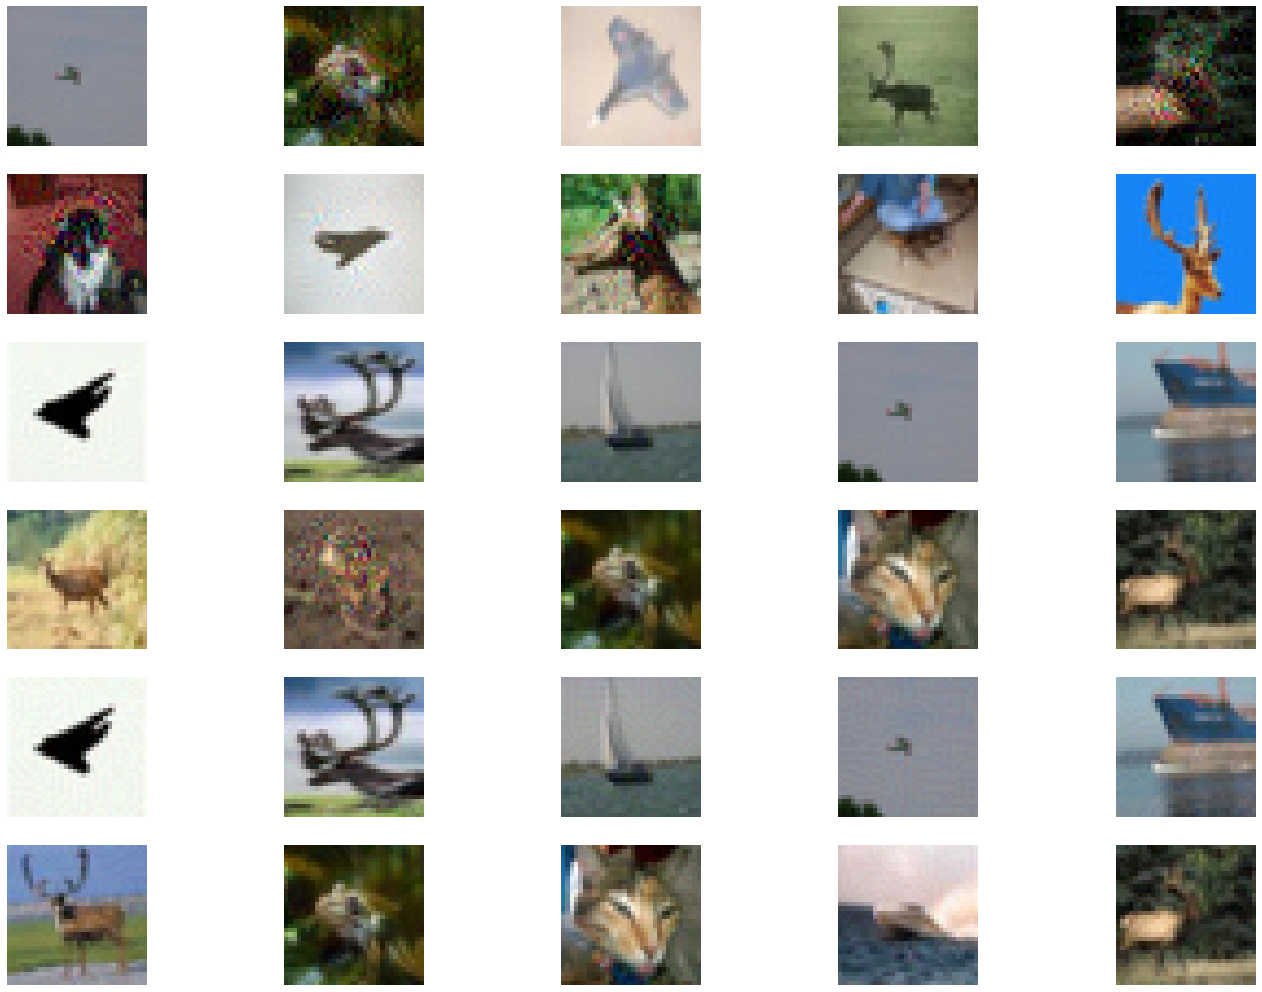

In [22]:
plt.figure(figsize=(24,18))
a=0
for i in range (10):
    deep = deep_idx[deep_target[i+a]] 
    newton = newton_idx[newton_target[i+a]] 
    pgd = pgd_idx[pgd_target[i+a]]
    ax = plt.subplot(6, 5, i+1)
    plt.imshow(x_test_Deep_cifar10[deep], cmap='gray')
    plt.axis("off")
    ax = plt.subplot(6, 5, i+11)
    plt.imshow(x_test_Newton_cifar10[newton], cmap='gray')
    plt.axis("off")
    ax = plt.subplot(6, 5, i+21)
    plt.imshow(x_test_PGD_cifar10[pgd], cmap='gray')
    plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


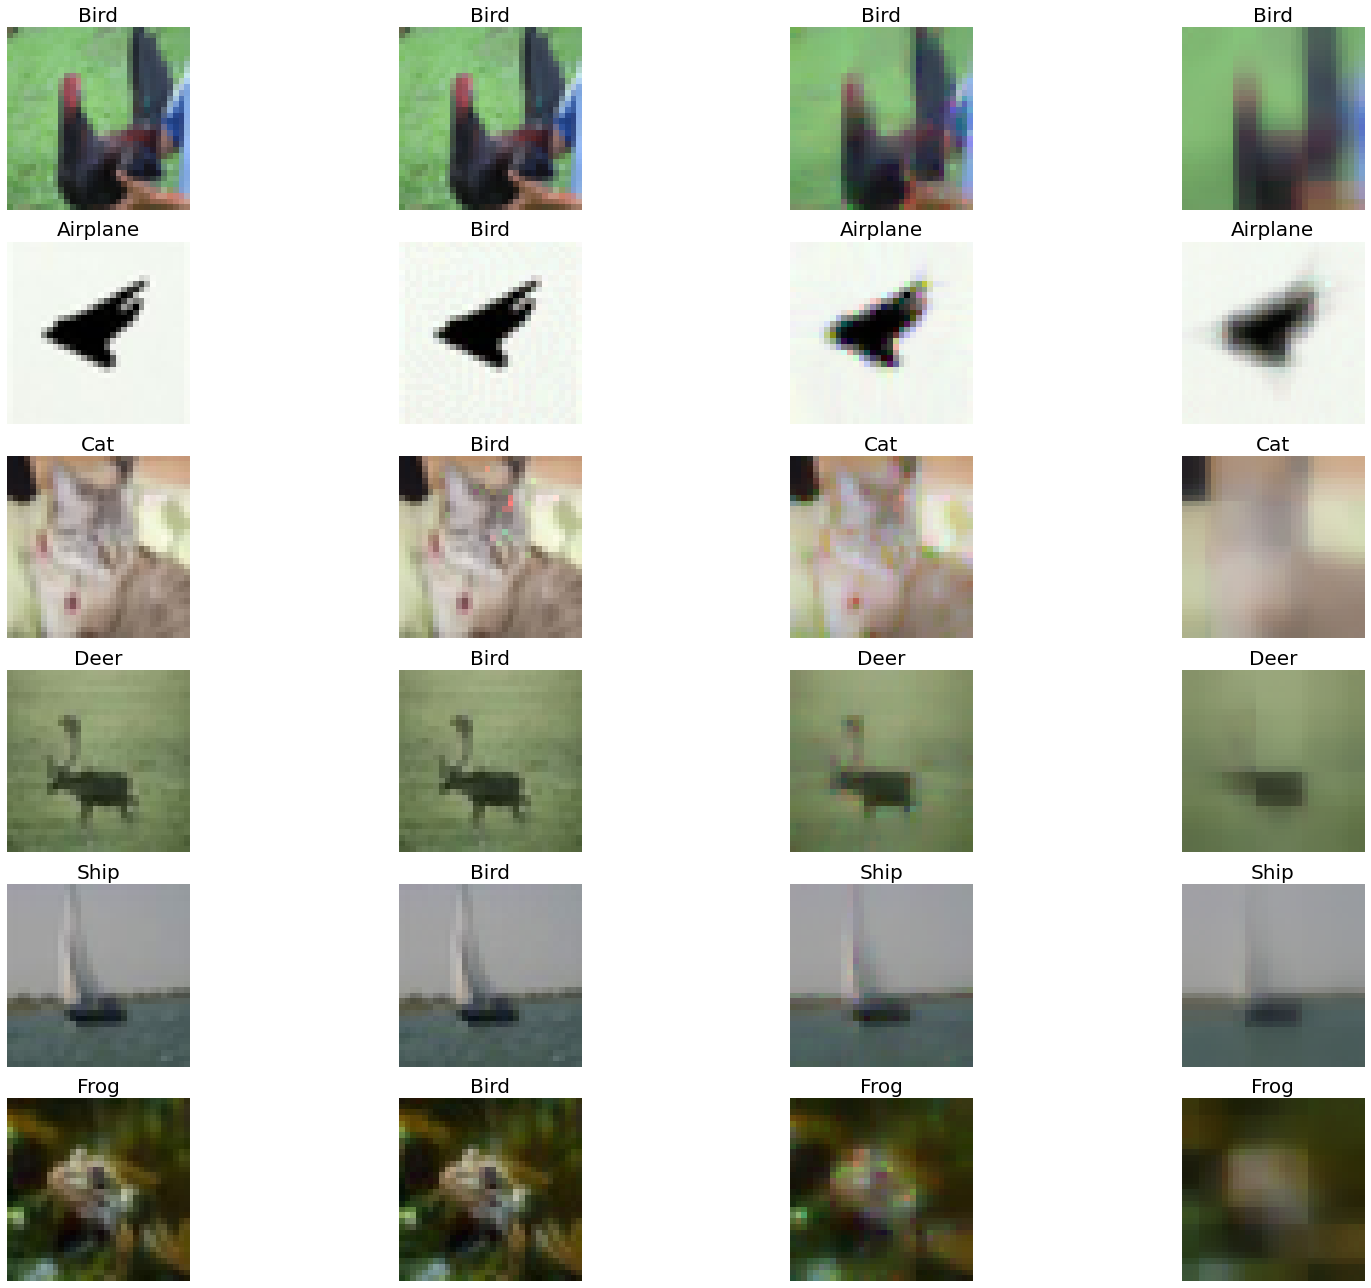

In [24]:
# Plot totalvarmin
plt.figure(figsize=(24,18))

#Plot original image
ax = plt.subplot(6, 4, 1)
plt.imshow(x_test_cln[cln], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(y_test_cln,axis=1)[cln])), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(6, 4, 1+4)
plt.imshow(x_test_cln[bim], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(y_test_cln,axis=1)[bim])), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(6, 4, 1+8)
plt.imshow(x_test_cln[jsma], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(y_test_cln,axis=1)[jsma])), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(6, 4, 1+12)
plt.imshow(x_test_cln[deep], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(y_test_cln,axis=1)[deep])), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(6, 4, 1+16)
plt.imshow(x_test_cln[newton], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(y_test_cln,axis=1)[newton])), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(6, 4, 1+20)
plt.imshow(x_test_cln[pgd], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(y_test_cln,axis=1)[pgd])), fontsize=20, loc='center', wrap=True)
plt.axis("off")

#Plot adversarial examples

ax = plt.subplot(6, 4, 2)
plt.imshow(x_test_cln[cln], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(y_test_cln,axis=1)[cln])), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(6, 4, 2+4)
plt.imshow(x_test_BIM_cifar10[bim], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(predictions_bim,axis=1)[bim])), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(6, 4, 2+8)
plt.imshow(x_test_JSMA_cifar10[jsma], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(predictions_jsma,axis=1)[jsma])), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(6, 4, 2+12)
plt.imshow(x_test_Deep_cifar10[deep], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(predictions_deep,axis=1)[deep])), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(6, 4, 2+16)
plt.imshow(x_test_Newton_cifar10[newton], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(predictions_newton,axis=1)[newton])), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(6, 4, 2+20)
plt.imshow(x_test_PGD_cifar10[pgd], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(predictions_pgd,axis=1)[pgd])), fontsize=20, loc='center', wrap=True)
plt.axis("off")

#Plot totalvarmin lambda=0.1
ax = plt.subplot(6, 4, 3)
plt.imshow(cln_tvm05[cln], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(predictions_cln_tvm05,axis=1)[cln])), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(6, 4, 3+4)
plt.imshow(bim_tvm05[bim], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(predictions_bim_tvm05,axis=1)[bim])), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(6, 4, 3+8)
plt.imshow(jsma_tvm05[jsma], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(predictions_jsma_tvm05,axis=1)[jsma])), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(6, 4, 3+12)
plt.imshow(deep_tvm05[deep], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(predictions_deep_tvm05,axis=1)[deep])), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(6, 4, 3+16)
plt.imshow(newton_tvm05[newton], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(predictions_newton_tvm05,axis=1)[newton])), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(6, 4, 3+20)
plt.imshow(pgd_tvm05[pgd], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(predictions_pgd_tvm05,axis=1)[pgd])), fontsize=20, loc='center', wrap=True)
plt.axis("off")

#Plot totalvarmin lambda=0.5
ax = plt.subplot(6, 4, 4)
plt.imshow(cln_tvm5[cln], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(predictions_cln_tvm5,axis=1)[cln])), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(6, 4, 4+4)
plt.imshow(bim_tvm5[bim], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(predictions_bim_tvm5,axis=1)[bim])), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(6, 4, 4+8)
plt.imshow(jsma_tvm5[jsma], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(predictions_jsma_tvm5,axis=1)[jsma])), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(6, 4, 4+12)
plt.imshow(deep_tvm5[deep], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(predictions_deep_tvm5,axis=1)[deep])), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(6, 4, 4+16)
plt.imshow(newton_tvm5[newton], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(predictions_newton_tvm5,axis=1)[newton])), fontsize=20, loc='center', wrap=True)
plt.axis("off")

ax = plt.subplot(6, 4, 4+20)
plt.imshow(pgd_tvm5[pgd], cmap='gray')
ax.set_title('{:}'.format(cifar10_class(np.argmax(predictions_pgd_tvm5,axis=1)[pgd])), fontsize=20, loc='center', wrap=True)
plt.axis("off")
            

image_path = '/home/cyber/Desktop/Adrian/Plots/TotalVarMin_CIFAR-10_reference (horizontal).png'
plt.savefig(image_path, dpi=500, transparent=True)                       
plt.tight_layout()
plt.show()